In [14]:
# === Cell 1: Setup & Configuration ===
import os, warnings, re, json
from pathlib import Path
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 110

# Sklearn
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# Reproducibility
warnings.filterwarnings("ignore")
np.random.seed(42)

PROJECT_ROOT = "/home/abdi/drought-prediction"
CFG = {
    "embeddings_folder": os.path.join(PROJECT_ROOT, "data/Hotspot_final_tabular/"),
    "main_data_path": os.path.join(PROJECT_ROOT, "data/Features/final_dataset.csv"),
    "results_dir": os.path.join(PROJECT_ROOT, "dissertation_results"),
    "split_date": "2022-01-01",      # label-date boundary for TEST
    "random_state": 42,
    "pca_variance": 0.95,            # 0.95 good for annual. Try 0.90 for SPI_12 if you want.
    "lags_non_spi": [1, 2],          # for embeddings/climate
    "rolling_windows": [2],          # annual smoothing
    "topk_other": 100,               # keep top-K non-embedding features after importance filter
}
Path(CFG["results_dir"]).mkdir(parents=True, exist_ok=True)
print("✅ Setup complete →", CFG["results_dir"])


✅ Setup complete → /home/abdi/drought-prediction/dissertation_results


In [15]:
# === Cell 2: Load & Harmonize Data ===
from glob import glob

def load_embeddings(folder):
    files = glob(os.path.join(folder, "*/*/*.csv"))
    if not files:
        raise FileNotFoundError(f"No embedding CSVs found: {folder}")
    emb = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    emb.rename(columns={"Year":"year"}, inplace=True)
    if "ADM0_NAME" in emb.columns: emb["ADM0_NAME"] = emb["ADM0_NAME"].astype(str).str.title()
    for c in ["ADM1_NAME","ADM2_NAME"]:
        if c in emb.columns: emb[c] = emb[c].astype(str)
    return emb

def load_main(path):
    main = pd.read_csv(path)
    main.rename(columns={"Country":"ADM0_NAME","Year":"year"}, inplace=True)
    if "Date" in main.columns:
        main["Date"] = pd.to_datetime(main["Date"])
    else:
        main["Date"] = pd.to_datetime(main["year"].astype(int).astype(str) + "-01-01")
    if "ADM0_NAME" in main.columns: main["ADM0_NAME"] = main["ADM0_NAME"].astype(str).str.title()
    for c in ["ADM1_NAME","ADM2_NAME"]:
        if c in main.columns: main[c] = main[c].astype(str)
    return main

embeddings_df = load_embeddings(CFG["embeddings_folder"])
main_df = load_main(CFG["main_data_path"])

merged = pd.merge(main_df, embeddings_df, on=["ADM0_NAME","year"], how="inner")
merged = merged.sort_values(by=[c for c in ["ADM2_NAME","ADM1_NAME"] if c in merged.columns] + ["Date"])
merged = merged.set_index(pd.to_datetime(merged["Date"]))
merged.index.name = "date"

print(f"Embeddings: {embeddings_df.shape} | Main: {main_df.shape} | Merged: {merged.shape}")
display(merged.head())


Embeddings: (3144, 70) | Main: (1200, 24) | Merged: (37728, 92)


,Date,year,ADM0_NAME,Precip_mm,Temp_K,SoilMoisture,Evaporation,NDVI,SPI_1,SPI_3,...,A57,A58,A59,A60,A61,A62,A63,ADM1_NAME,ADM2_NAME,.geo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017-01-01,2017,Somalia,0.237345,297.946331,0.063079,-0.000145,0.206394,-0.743073,-0.433881,...,0.142859,-0.127979,-0.004258,-0.073566,0.021017,0.031462,0.013122,Shabelle Dhexe,Adan Yabaal,"{""type"":""Polygon"",""coordinates"":[[[46.39098908..."
2017-01-02,2017-01-02,2017,Somalia,0.612728,299.142550,0.064612,-0.000201,0.187196,0.672196,0.452328,...,0.142859,-0.127979,-0.004258,-0.073566,0.021017,0.031462,0.013122,Shabelle Dhexe,Adan Yabaal,"{""type"":""Polygon"",""coordinates"":[[[46.39098908..."
2017-01-03,2017-01-03,2017,Somalia,5.041892,300.437586,0.062590,-0.000173,0.180455,-0.295607,-0.597959,...,0.142859,-0.127979,-0.004258,-0.073566,0.021017,0.031462,0.013122,Shabelle Dhexe,Adan Yabaal,"{""type"":""Polygon"",""coordinates"":[[[46.39098908..."
2017-01-04,2017-01-04,2017,Somalia,42.447889,301.266175,0.086708,-0.000657,0.207608,-0.911490,-0.837005,...,0.142859,-0.127979,-0.004258,-0.073566,0.021017,0.031462,0.013122,Shabelle Dhexe,Adan Yabaal,"{""type"":""Polygon"",""coordinates"":[[[46.39098908..."
2017-01-05,2017-01-05,2017,Somalia,66.485073,300.563018,0.147330,-0.001801,0.265466,0.603548,-0.531758,...,0.142859,-0.127979,-0.004258,-0.073566,0.021017,0.031462,0.013122,Shabelle Dhexe,Adan Yabaal,"{""type"":""Polygon"",""coordinates"":[[[46.39098908..."


In [16]:
# === Cell 3: Frequency, Horizon & Targets ===
TARGETS = ["SPI_3", "SPI_6", "SPI_12"]
assert all(t in merged.columns for t in TARGETS), "Missing SPI columns."

is_monthly = merged.index.to_series().dt.month.nunique() > 1
forecast_horizon = 3 if is_monthly else 1

print("Time range:", str(merged.index.min().date()), "→", str(merged.index.max().date()))
print("Detected frequency:", "Monthly" if is_monthly else "Annual")
print("Forecast horizon (steps):", forecast_horizon)
if "ADM0_NAME" in merged.columns:
    print("Countries:", merged["ADM0_NAME"].nunique())
if "ADM2_NAME" in merged.columns:
    print("Districts:", merged["ADM2_NAME"].nunique())


Time range: 2017-01-01 → 2024-01-12
Detected frequency: Annual
Forecast horizon (steps): 1
Countries: 4
Districts: 388


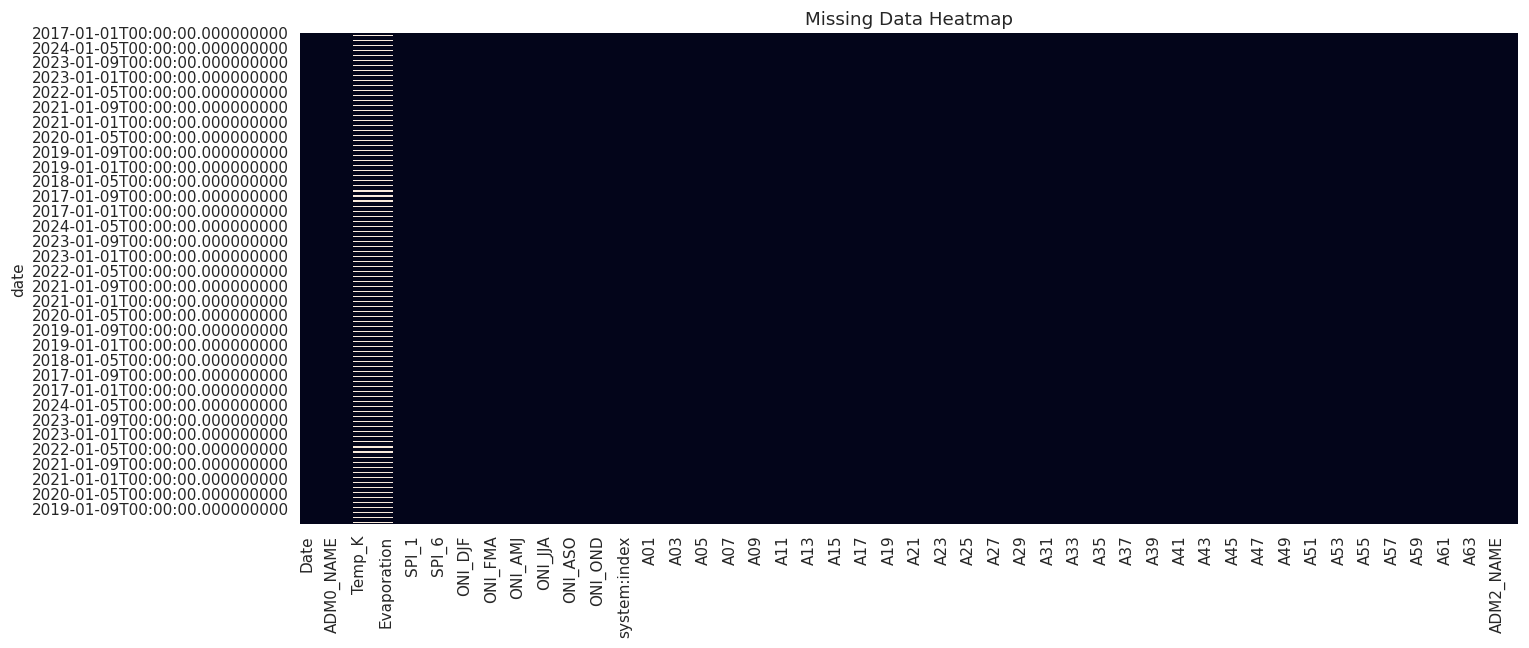

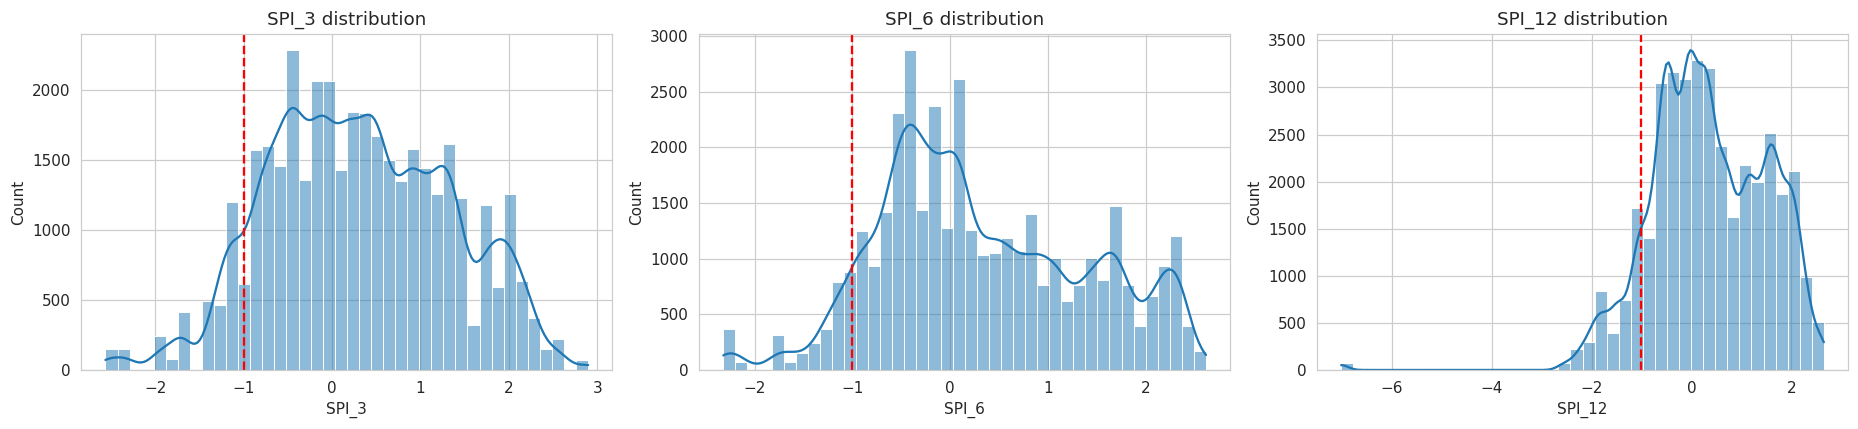

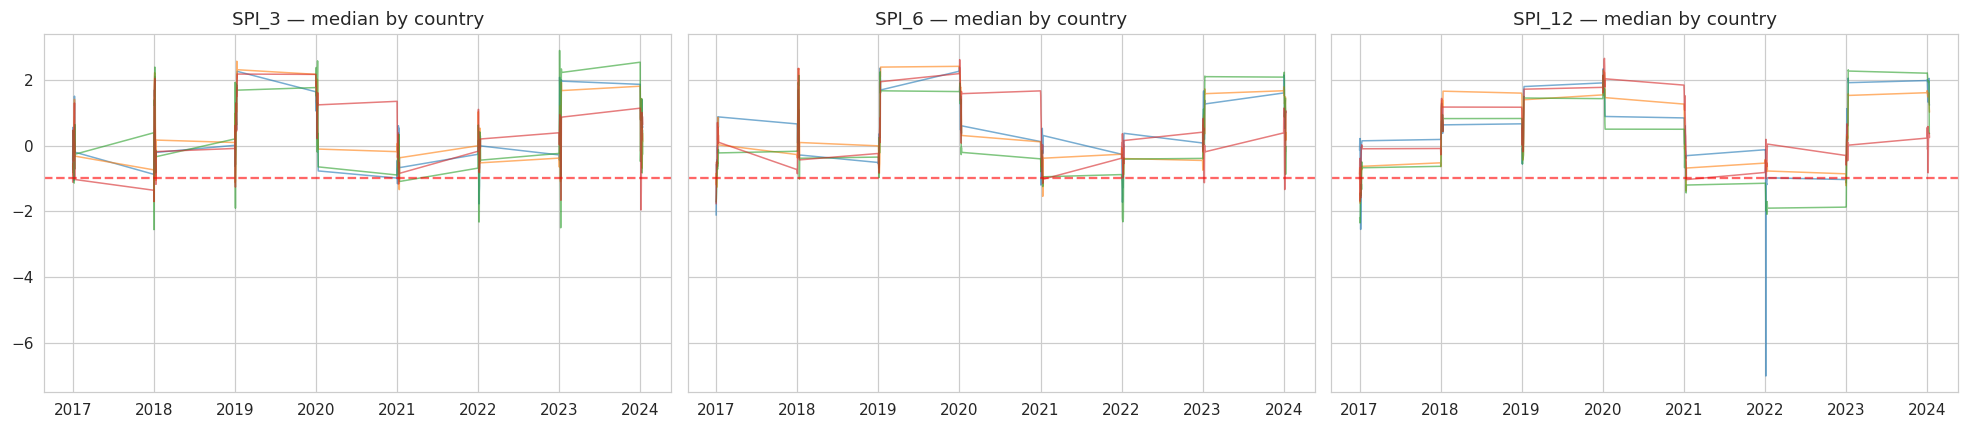

Drought rate SPI_3 (<-1): 0.093


In [17]:
# === Cell 4: EDA (useful set) ===
save_dir = CFG["results_dir"]

# Missingness heatmap
plt.figure(figsize=(14,6)); sns.heatmap(merged.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.tight_layout(); plt.savefig(os.path.join(save_dir, "eda_missingness.png")); plt.show()

# SPI distributions & drought threshold
fig, axes = plt.subplots(1,3, figsize=(17,4))
for i, t in enumerate(TARGETS):
    sns.histplot(merged[t].dropna(), bins=40, kde=True, ax=axes[i])
    axes[i].axvline(-1, ls="--", c="red"); axes[i].set_title(f"{t} distribution")
plt.tight_layout(); plt.savefig(os.path.join(save_dir, "eda_spi_distributions.png")); plt.show()

# Country temporal medians
if "ADM0_NAME" in merged.columns:
    fig, axes = plt.subplots(1,3, figsize=(18,4), sharey=True)
    for i, t in enumerate(TARGETS):
        tmp = merged[[t,"ADM0_NAME"]].dropna().groupby(["date","ADM0_NAME"]).median().reset_index()
        for country, g in tmp.groupby("ADM0_NAME"):
            axes[i].plot(g["date"], g[t], alpha=0.6, lw=1)
        axes[i].axhline(-1, c="red", ls="--", alpha=0.6); axes[i].set_title(f"{t} — median by country")
    plt.tight_layout(); plt.savefig(os.path.join(save_dir, "eda_temporal_country.png")); plt.show()

print("Drought rate SPI_3 (<-1):", round((merged["SPI_3"]<-1).mean(),3))


In [18]:
# === Cell 5: Feature Engineering (lags, rolling, SPI memory) ===
df = merged.copy()

# Embedding columns
emb_cols = sorted([c for c in df.columns if re.fullmatch(r"A\d{2}", c)])
print("Embedding features:", len(emb_cols))

# Climate/aux numeric (exclude SPI + meta)
exclude_meta = {"year","system:index","Date","date","ADM0_NAME","ADM1_NAME","ADM2_NAME"}
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
climate_like = [c for c in num_cols if c not in emb_cols and not c.startswith("SPI_") and c not in exclude_meta]
print("Climate/aux candidates:", len(climate_like))

base_features = emb_cols + climate_like
group_key = "ADM2_NAME" if "ADM2_NAME" in df.columns else ("ADM1_NAME" if "ADM1_NAME" in df.columns else "ADM0_NAME")

# Lags for non-SPI features
for lag in CFG["lags_non_spi"]:
    for col in base_features:
        df[f"{col}_lag{lag}"] = df.groupby(group_key)[col].shift(lag)

# Rolling means (annual smoothing)
for win in CFG["rolling_windows"]:
    for col in climate_like:
        df[f"{col}_roll{win}"] = df.groupby(group_key)[col].transform(lambda s: s.rolling(win, min_periods=1).mean())

# SPI memory: lag1/2/3 + delta + accel (change-of-change)
for t in TARGETS:
    df[f"{t}_lag1"] = df.groupby(group_key)[t].shift(1)
    df[f"{t}_lag2"] = df.groupby(group_key)[t].shift(2)
    df[f"{t}_lag3"] = df.groupby(group_key)[t].shift(3)
    df[f"{t}_delta"] = df[t] - df[f"{t}_lag1"]
    df[f"{t}_accel"] = df[f"{t}_lag1"] - df[f"{t}_lag2"]

# Drop warm-up rows that miss SPI memory
need = [f"{t}_lag2" for t in TARGETS] + [f"{t}_lag3" for t in TARGETS]
df = df.loc[~df[need].isnull().any(axis=1)].copy()
print("After lagging — shape:", df.shape)

# Future targets (y_{t+H})
for t in TARGETS:
    df[f"{t}_future"] = df.groupby(group_key)[t].shift(-forecast_horizon)

df = df.loc[~df[[f"{t}_future" for t in TARGETS]].isnull().any(axis=1)].copy()
print("After building futures — shape:", df.shape)

# Label date (where the target lives)
df["label_date"] = df.index + (pd.offsets.DateOffset(months=3) if forecast_horizon==3 else pd.offsets.DateOffset(years=1))


Embedding features: 64
Climate/aux candidates: 17
After lagging — shape: (36564, 286)
After building futures — shape: (36176, 289)


In [19]:
# === Cell 6: Chronological Split + Importance-based Feature Trim ===
split_date = pd.to_datetime(CFG["split_date"])
train_df = df.loc[df["label_date"] < split_date].copy()
test_df  = df.loc[df["label_date"] >= split_date].copy()
print(f"Train labels: {train_df['label_date'].min().date()} → {train_df['label_date'].max().date()}  (n={len(train_df)})")
print(f"Test  labels: {test_df['label_date'].min().date()} → {test_df['label_date'].max().date()}   (n={len(test_df)})")

# Candidate features = numeric minus targets/futures/meta
exclude_cols = set(TARGETS + [f"{t}_future" for t in TARGETS] + ["year","Date","system:index","label_date"])
all_numeric = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
candidate_features = [c for c in all_numeric if c not in exclude_cols]

# Select top-K non-embedding features by RF importance (on SPI_12_future as yardstick)
from sklearn.ensemble import RandomForestRegressor
other_candidates = [c for c in candidate_features if not re.match(r"^A\d{2}(_lag\d+)?$", c)]
X_fs = train_df[other_candidates].fillna(train_df[other_candidates].median())
rf_fs = RandomForestRegressor(n_estimators=800, random_state=CFG["random_state"], n_jobs=-1).fit(X_fs, train_df["SPI_12_future"].values)
imp = pd.Series(rf_fs.feature_importances_, index=other_candidates).sort_values(ascending=False)
selected_other = imp.head(min(CFG["topk_other"], len(imp))).index.tolist()

# Final feature list = embeddings(+lags) + SPI memory + selected other
emb_like = [c for c in candidate_features if re.match(r"^A\d{2}(_lag\d+)?$", c)]
spi_keep = [c for c in candidate_features if c.startswith(("SPI_3_lag","SPI_6_lag","SPI_12_lag")) or c.endswith(("_delta","_accel"))]
feature_cols = sorted(set(emb_like + spi_keep + selected_other))
print("Final feature count (pre-PCA):", len(feature_cols))


Train labels: 2018-01-01 → 2021-01-12  (n=17700)
Test  labels: 2022-01-01 → 2025-01-12   (n=18476)
Final feature count (pre-PCA): 276


In [20]:
# === Cell 7: Preprocessing (Imputer/Scaler; PCA on embeddings) ===
emb_regex = re.compile(r"^A\d{2}(_lag\d+)?$")
emb_feature_cols   = [c for c in feature_cols if emb_regex.match(c)]
other_feature_cols = [c for c in feature_cols if c not in emb_feature_cols]
print(f"Features → Embeddings-related: {len(emb_feature_cols)} | Other: {len(other_feature_cols)}")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

emb_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=CFG["pca_variance"]))
])
other_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
preprocessor = ColumnTransformer([
    ("emb", emb_pipeline, emb_feature_cols),
    ("other", other_pipeline, other_feature_cols)
], remainder="drop")

X_train = preprocessor.fit_transform(train_df[feature_cols])
X_test  = preprocessor.transform(test_df[feature_cols])
y_train = {t: train_df[f"{t}_future"].values for t in TARGETS}
y_test  = {t: test_df[f"{t}_future"].values for t in TARGETS}
y_pers_test = {t: test_df[t].values for t in TARGETS}  # persistence baseline

print("✅ Preprocessing done:", X_train.shape, X_test.shape)
try:
    pca_emb = preprocessor.named_transformers_["emb"].named_steps["pca"]
    print(f"PCA(embeddings) → {pca_emb.n_components_} comps; cum.var≈{np.cumsum(pca_emb.explained_variance_ratio_)[-1]:.3f}")
except Exception:
    pass


Features → Embeddings-related: 192 | Other: 84
✅ Preprocessing done: (17700, 104) (18476, 104)
PCA(embeddings) → 20 comps; cum.var≈0.952


In [21]:
# === Cell 8: Define Models (bigger bench) ===
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Optional XGB
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

def get_models():
    models = {
        "Ridge": Ridge(alpha=0.8, random_state=CFG["random_state"]),
        "Lasso": Lasso(alpha=0.0005, max_iter=4000, random_state=CFG["random_state"]),
        "ElasticNet": ElasticNet(alpha=0.0008, l1_ratio=0.2, max_iter=4000, random_state=CFG["random_state"]),
        "KNN": KNeighborsRegressor(n_neighbors=25, weights="distance"),
        "RandomForest": RandomForestRegressor(
            n_estimators=900, max_depth=None, min_samples_split=4, min_samples_leaf=2,
            max_features="sqrt", n_jobs=-1, random_state=CFG["random_state"]
        ),
        "ExtraTrees": ExtraTreesRegressor(
            n_estimators=900, max_depth=None, min_samples_split=2, min_samples_leaf=1,
            max_features="sqrt", n_jobs=-1, random_state=CFG["random_state"]
        ),
        "GradientBoosting": GradientBoostingRegressor(
            n_estimators=700, learning_rate=0.05, max_depth=3, subsample=0.9,
            random_state=CFG["random_state"]
        ),
        "HistGradientBoosting": HistGradientBoostingRegressor(
            max_depth=None, learning_rate=0.06, max_iter=600, l2_regularization=0.02,
            random_state=CFG["random_state"]
        ),
    }
    if XGB_AVAILABLE:
        models["XGBoost"] = xgb.XGBRegressor(
            n_estimators=1200, learning_rate=0.03, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="reg:squarederror", n_jobs=-1, random_state=CFG["random_state"],
            tree_method="hist"
        )
    return models

models = get_models()
print("Models:", ", ".join(models.keys()))


Models: Ridge, Lasso, ElasticNet, KNN, RandomForest, ExtraTrees, GradientBoosting, HistGradientBoosting, XGBoost



▶ Target: SPI_3 (predicting 1 step(s) ahead))
Persistence → RMSE=0.789, MAE=0.599, R2=0.251
Ridge                → RMSE=1.815, MAE=1.313, R2=-2.968
Lasso                → RMSE=1.699, MAE=1.307, R2=-2.476
ElasticNet           → RMSE=1.736, MAE=1.327, R2=-2.630
KNN                  → RMSE=1.145, MAE=0.927, R2=-0.578
RandomForest         → RMSE=0.744, MAE=0.552, R2=0.333
ExtraTrees           → RMSE=0.819, MAE=0.624, R2=0.192
GradientBoosting     → RMSE=0.748, MAE=0.557, R2=0.325
HistGradientBoosting → RMSE=0.866, MAE=0.666, R2=0.096
XGBoost              → RMSE=0.851, MAE=0.660, R2=0.128

▶ Target: SPI_6 (predicting 1 step(s) ahead))
Persistence → RMSE=0.548, MAE=0.413, R2=0.647
Ridge                → RMSE=1.170, MAE=0.906, R2=-0.612
Lasso                → RMSE=1.057, MAE=0.820, R2=-0.316
ElasticNet           → RMSE=1.118, MAE=0.861, R2=-0.473
KNN                  → RMSE=1.208, MAE=0.993, R2=-0.718
RandomForest         → RMSE=0.753, MAE=0.581, R2=0.333
ExtraTrees           → RMSE=0.890, M

,Target,Model,RMSE,MAE,R2
0,SPI_12,GradientBoosting,0.601473,0.364204,0.696130
1,SPI_12,Persistence,0.697889,0.327051,0.590900
2,SPI_12,HistGradientBoosting,0.748296,0.532124,0.529670
3,SPI_12,XGBoost,0.812181,0.579602,0.445934
4,SPI_12,Lasso,0.998912,0.730340,0.161871
5,SPI_12,ElasticNet,1.050861,0.774695,0.072429
6,SPI_12,Ridge,1.144472,0.858148,-0.100188
7,SPI_12,RandomForest,1.174878,0.932786,-0.159424
8,SPI_12,ExtraTrees,1.290903,1.031294,-0.399728
9,SPI_12,KNN,1.770780,1.397140,-1.633816


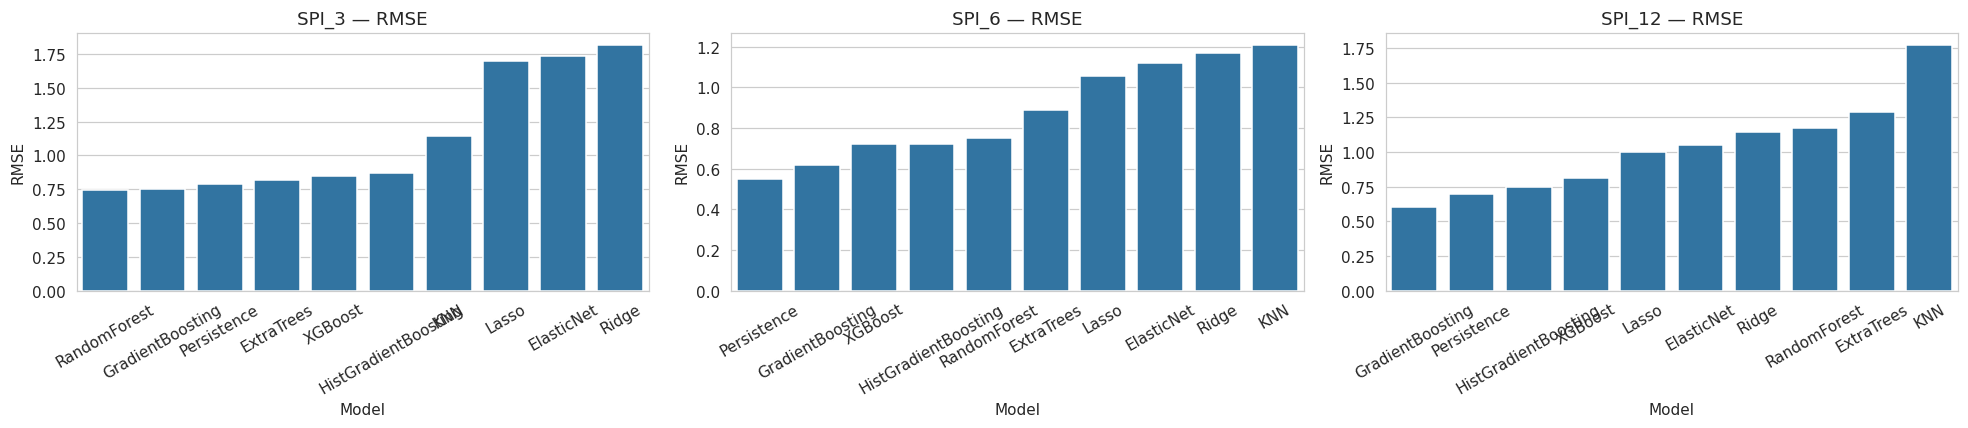

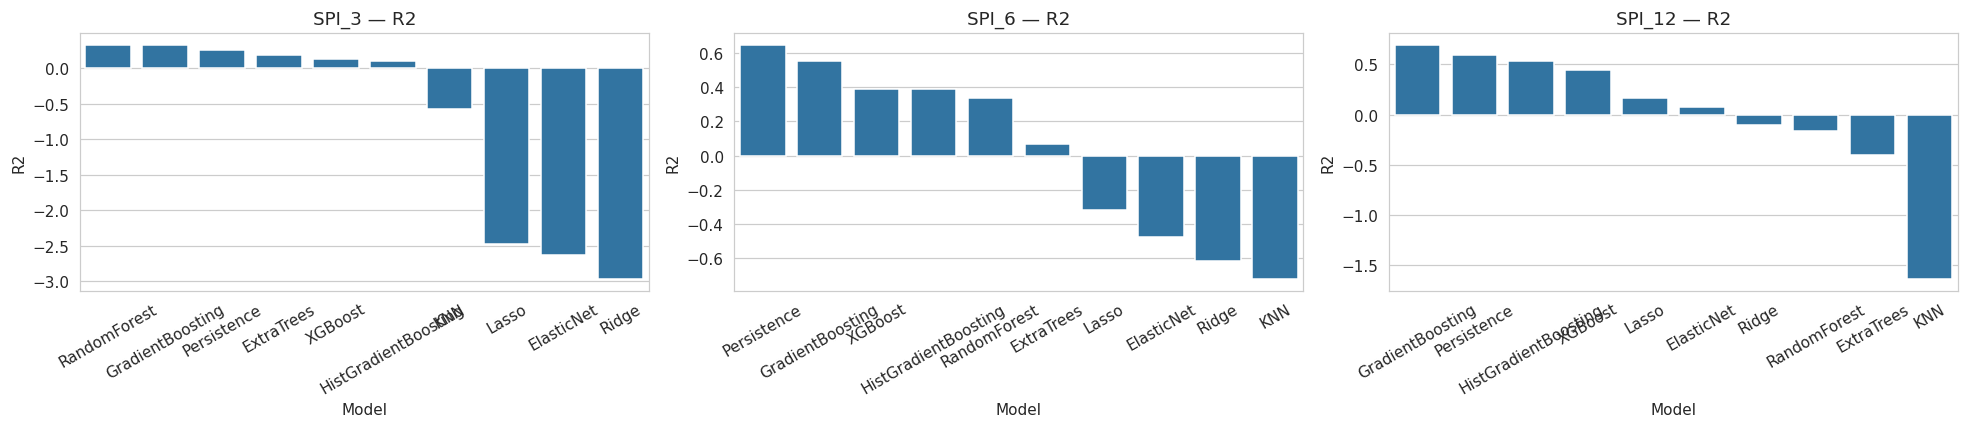

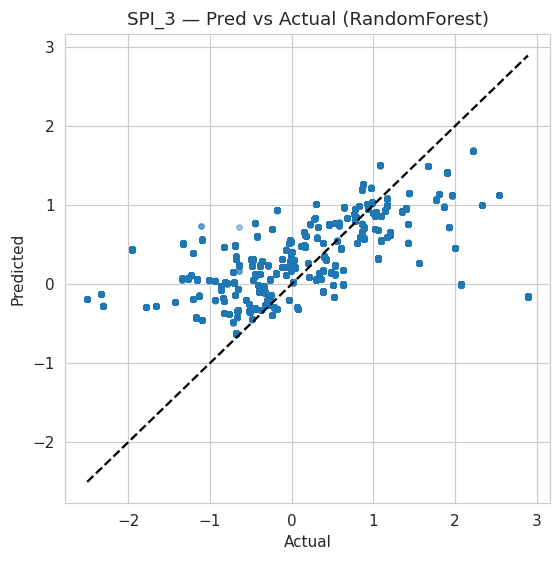

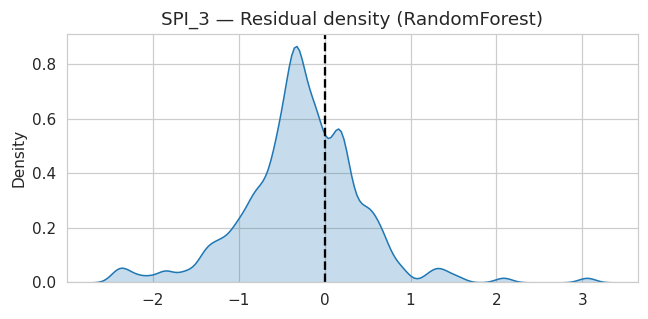

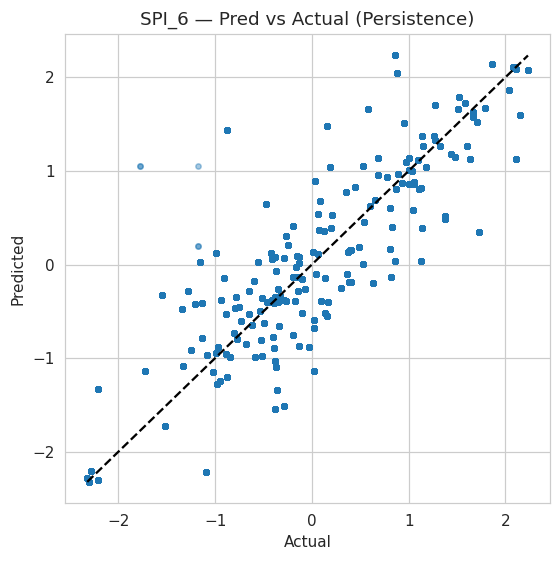

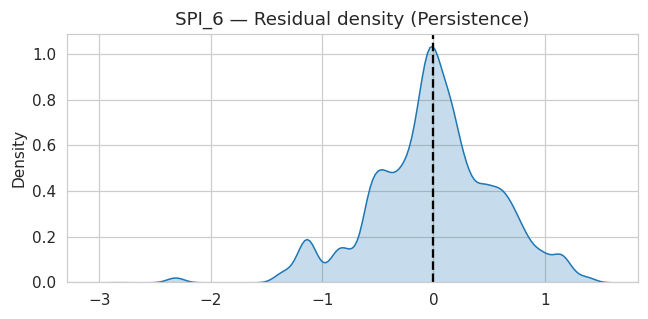

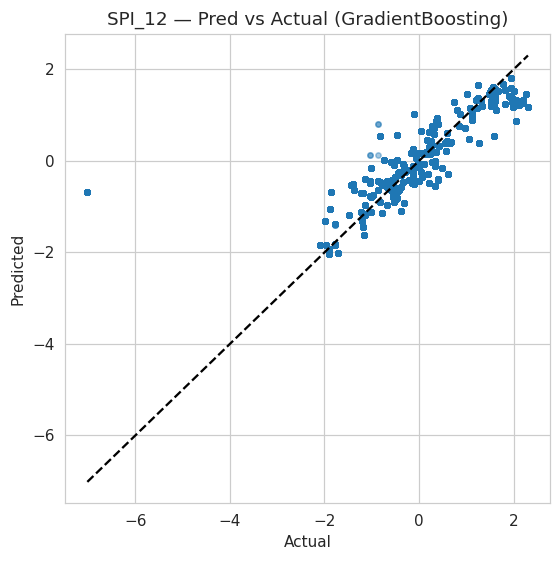

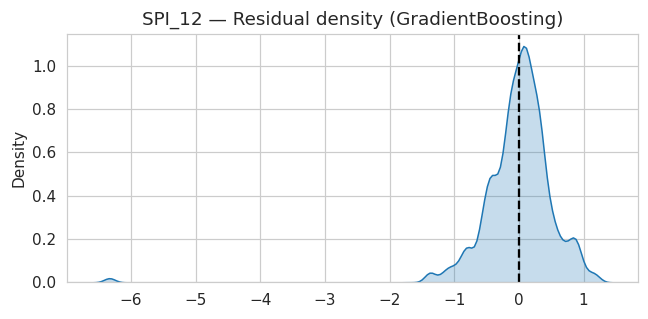

In [22]:
# === Cell 9: Train, Evaluate, Save + Figures ===
def eval_reg(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

all_results = []
trained_models = {t:{} for t in TARGETS}

for t in TARGETS:
    print("\n" + "="*80)
    print(f"▶ Target: {t} (predicting {forecast_horizon} step(s) ahead))")
    print("="*80)

    # Persistence baseline
    base = eval_reg(y_test[t], y_pers_test[t])
    all_results.append({"Target":t, "Model":"Persistence", **base})
    print(f"Persistence → RMSE={base['RMSE']:.3f}, MAE={base['MAE']:.3f}, R2={base['R2']:.3f}")

    for name, mdl in models.items():
        m = clone(mdl).fit(X_train, y_train[t])
        yhat = m.predict(X_test)
        met = eval_reg(y_test[t], yhat)
        all_results.append({"Target":t, "Model":name, **met})
        trained_models[t][name] = m
        print(f"{name:20s} → RMSE={met['RMSE']:.3f}, MAE={met['MAE']:.3f}, R2={met['R2']:.3f}")

res_df = pd.DataFrame(all_results).sort_values(["Target","RMSE"]).reset_index(drop=True)
out_csv = os.path.join(CFG["results_dir"], "model_results_regression.csv")
res_df.to_csv(out_csv, index=False)
print("\n✅ Saved results →", out_csv)
display(res_df)

# Plots: bar charts
def plot_metric(res, metric, fname):
    fig, axes = plt.subplots(1,3, figsize=(18,4))
    for i, t in enumerate(TARGETS):
        sub = res[res["Target"]==t]
        sns.barplot(data=sub, x="Model", y=metric, ax=axes[i])
        axes[i].set_title(f"{t} — {metric}")
        axes[i].tick_params(axis="x", rotation=30)
    plt.tight_layout(); plt.savefig(os.path.join(CFG["results_dir"], fname)); plt.show()
plot_metric(res_df, "RMSE", "rmse_by_model.png")
plot_metric(res_df, "R2", "r2_by_model.png")

# Pred vs actual & residuals for best model per target
for t in TARGETS:
    best = res_df[res_df["Target"]==t].iloc[0]
    best_name = best["Model"]
    yhat = y_pers_test[t] if best_name=="Persistence" else trained_models[t][best_name].predict(X_test)

    plt.figure(figsize=(5.2,5.2))
    plt.scatter(y_test[t], yhat, s=12, alpha=0.4)
    lims = [min(y_test[t].min(), yhat.min()), max(y_test[t].max(), yhat.max())]
    plt.plot(lims, lims, ls="--", c="k"); plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.title(f"{t} — Pred vs Actual ({best_name})")
    plt.tight_layout(); plt.savefig(os.path.join(CFG["results_dir"], f"{t}_pred_vs_actual_{best_name}.png")); plt.show()

    # Residual density
    res = y_test[t] - yhat
    plt.figure(figsize=(6,3))
    sns.kdeplot(res, fill=True); plt.axvline(0, c="k", ls="--")
    plt.title(f"{t} — Residual density ({best_name})")
    plt.tight_layout(); plt.savefig(os.path.join(CFG["results_dir"], f"{t}_residual_density_{best_name}.png")); plt.show()


In [23]:
# === Cell 9A: Expanding-Window CV on Training (robustness) ===
def expanding_windows(label_dates, n_splits=4, min_train_years=2):
    years = np.sort(pd.to_datetime(label_dates).dt.year.unique())
    for i in range(min_train_years, min(min_train_years+n_splits, len(years))):
        tr_years = years[:i]; va_year = years[i]
        tr_idx = label_dates.dt.year.isin(tr_years).values
        va_idx = (label_dates.dt.year == va_year).values
        yield np.where(tr_idx)[0], np.where(va_idx)[0]

def cv_rmse(model, X, y, dates):
    scores = []
    for tr, va in expanding_windows(dates):
        m = clone(model).fit(X[tr], y[tr])
        p = m.predict(X[va])
        scores.append(np.sqrt(mean_squared_error(y[va], p)))
    return np.mean(scores), np.std(scores)

print("CV RMSE on training (SPI_12):")
for name, mdl in models.items():
    mu, sd = cv_rmse(mdl, X_train, y_train["SPI_12"], train_df["label_date"])
    print(f"{name:20s} {mu:.3f} ± {sd:.3f}")


CV RMSE on training (SPI_12):
Ridge                0.635 ± 0.140
Lasso                0.714 ± 0.234
ElasticNet           0.613 ± 0.129
KNN                  1.765 ± 0.524
RandomForest         1.512 ± 0.744
ExtraTrees           1.524 ± 0.680
GradientBoosting     1.300 ± 0.320
HistGradientBoosting 1.601 ± 0.412
XGBoost              1.698 ± 0.449


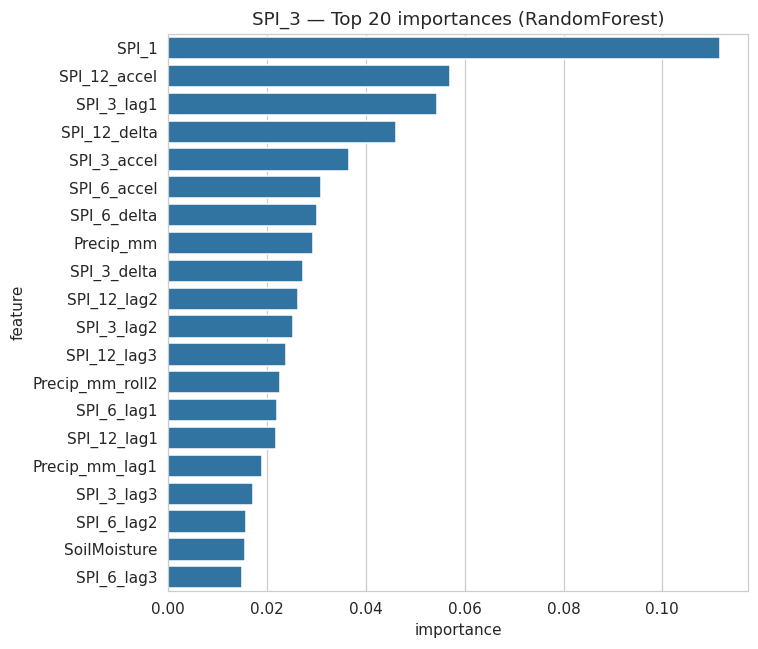

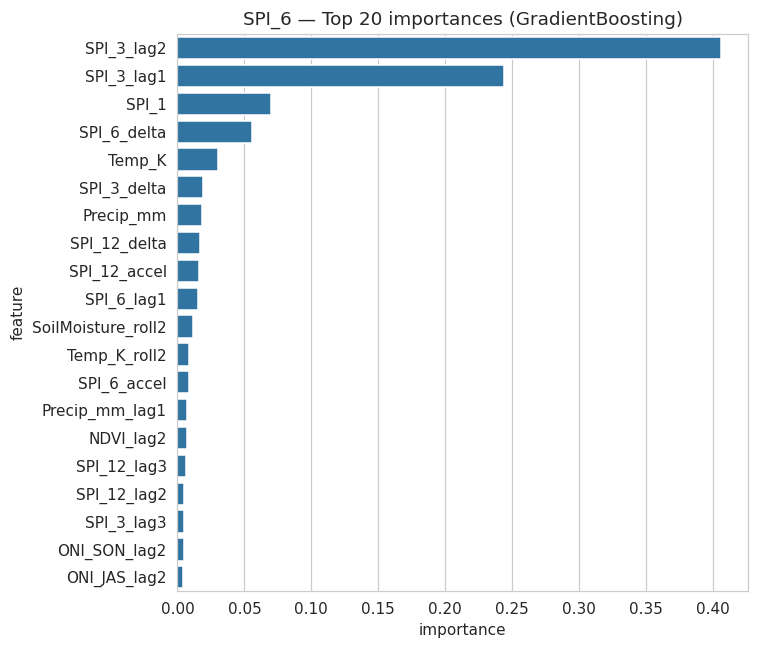

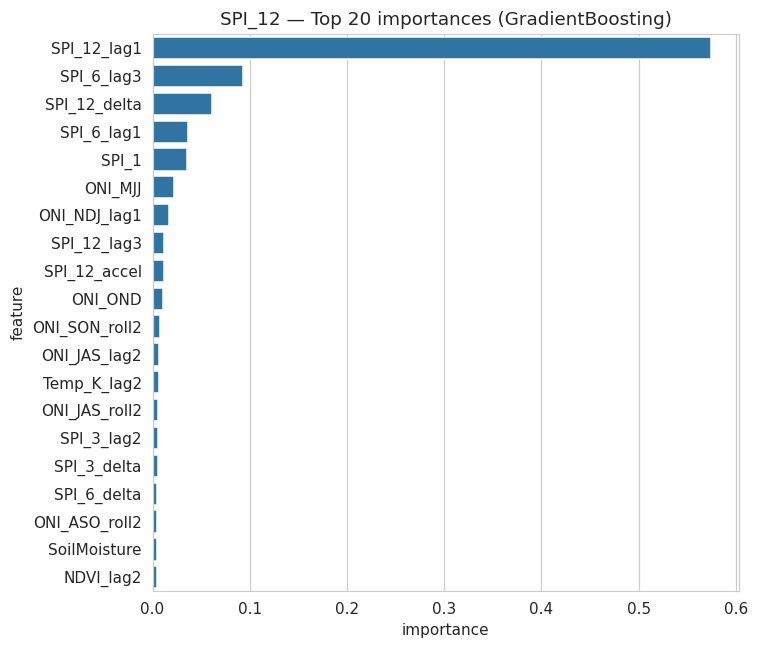

In [24]:
# === Cell 10: Interpretability (Top importances / coefficients) ===
def transformed_feature_names(preproc, emb_cols, other_cols):
    names = []
    try:
        n = preproc.named_transformers_["emb"].named_steps["pca"].n_components_
        names += [f"emb_PC{i+1}" for i in range(n)]
    except Exception:
        names += [f"emb_feat_{i+1}" for i in range(len(emb_cols))]
    names += other_cols
    return names

feat_names = transformed_feature_names(preprocessor, emb_feature_cols, other_feature_cols)

def plot_top_features(model, model_name, target, topn=20):
    if hasattr(model, "feature_importances_"):
        vals = model.feature_importances_
        df_imp = pd.DataFrame({"feature": feat_names, "importance": vals}).sort_values("importance", ascending=False).head(topn)
        plt.figure(figsize=(7,6)); sns.barplot(data=df_imp, x="importance", y="feature")
        plt.title(f"{target} — Top {topn} importances ({model_name})")
        plt.tight_layout(); plt.savefig(os.path.join(CFG["results_dir"], f"{target}_importances_{model_name}.png")); plt.show()
    elif hasattr(model, "coef_"):
        coefs = np.ravel(model.coef_); dfc = pd.DataFrame({"feature": feat_names, "coef": coefs})
        dfc["abs"] = dfc["coef"].abs(); dfc = dfc.sort_values("abs", ascending=False).head(topn)
        plt.figure(figsize=(7,6)); sns.barplot(data=dfc, x="abs", y="feature")
        plt.title(f"{target} — Top {topn} |coef| ({model_name})")
        plt.tight_layout(); plt.savefig(os.path.join(CFG["results_dir"], f"{target}_coef_{model_name}.png")); plt.show()

for t in TARGETS:
    sub = res_df[(res_df["Target"]==t) & (res_df["Model"]!="Persistence")].sort_values("RMSE")
    if len(sub)==0: continue
    best_name = sub.iloc[0]["Model"]
    plot_top_features(trained_models[t][best_name], best_name, t, topn=20)


In [26]:
# === Cell 11 (Optional): Quick tuning for the best target(s) ===
# If you want to push SPI_12 further, tune GradientBoosting & XGBoost here (optional).
from scipy.stats import randint, uniform

def rmse_scorer(yt, yp): return np.sqrt(mean_squared_error(yt, yp))

def tune_gb(target="SPI_12"):
    ytr = y_train[target]
    gb = GradientBoostingRegressor(random_state=CFG["random_state"])
    grid = {
        "n_estimators": randint(600, 1600),
        "learning_rate": uniform(0.01, 0.12),
        "max_depth": randint(2, 5),
        "subsample": uniform(0.6, 0.4),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "loss": ["squared_error","huber"],
    }
    search = RandomizedSearchCV(gb, grid, n_iter=35, scoring=("neg_root_mean_squared_error"),
                                cv=3, n_jobs=-1, verbose=1, random_state=CFG["random_state"])
    search.fit(X_train, ytr)
    print("Best GB:", search.best_params_, "CV RMSE:", -search.best_score_)
    return search.best_estimator_

def tune_xgb(target="SPI_12"):
    try:
        import xgboost as xgb
    except Exception:
        print("xgboost not installed. Skipping.")
        return None
    ytr = y_train[target]
    model = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=CFG["random_state"], tree_method="hist")
    grid = {
        "n_estimators": randint(900, 2200),
        "learning_rate": uniform(0.01, 0.12),
        "max_depth": randint(3, 9),
        "subsample": uniform(0.6, 0.4),
        "colsample_bytree": uniform(0.6, 0.4),
        "reg_lambda": uniform(0.0, 2.0),
    }
    search = RandomizedSearchCV(model, grid, n_iter=35, scoring=("neg_root_mean_squared_error"),
                                cv=3, n_jobs=-1, verbose=1, random_state=CFG["random_state"])
    search.fit(X_train, ytr)
    print("Best XGB:", search.best_params_, "CV RMSE:", -search.best_score_)
    return search.best_estimator_

# Example usage:
# gb_best = tune_gb("SPI_12"); models["GradientBoosting"] = gb_best
# xgb_best = tune_xgb("SPI_12"); 
# Re-run Cell 9 after updating models to refresh the table/plots.



Logistic: thr=0.50 | BalAcc=0.530 F1=0.166 Recall=0.212 Precision=0.137 | ROC-AUC=0.567 PR-AUC=0.118
CM [[TN,FP],[FN,TP]]:
 [[14040  2543]
 [ 1491   402]]
              precision    recall  f1-score   support

           0      0.904     0.847     0.874     16583
           1      0.137     0.212     0.166      1893

    accuracy                          0.782     18476
   macro avg      0.520     0.530     0.520     18476
weighted avg      0.825     0.782     0.802     18476


RF_cal: thr=0.50 | BalAcc=0.500 F1=0.000 Recall=0.000 Precision=0.000 | ROC-AUC=0.721 PR-AUC=0.188
CM [[TN,FP],[FN,TP]]:
 [[16583     0]
 [ 1893     0]]
              precision    recall  f1-score   support

           0      0.898     1.000     0.946     16583
           1      0.000     0.000     0.000      1893

    accuracy                          0.898     18476
   macro avg      0.449     0.500     0.473     18476
weighted avg      0.806     0.898     0.849     18476


XGB_cal: thr=0.50 | BalAcc=0.571 F1

,Model,Threshold,BalancedAcc,F1,Recall,Precision,ROC_AUC,PR_AUC,TN,FP,FN,TP
2,XGB_cal,0.5,0.571277,0.233681,0.207079,0.268126,0.727984,0.221630,15513,1070,1501,392
0,Logistic,0.5,0.529506,0.166184,0.212361,0.136503,0.567359,0.117655,14040,2543,1491,402
1,RF_cal,0.5,0.500000,0.000000,0.000000,0.000000,0.721153,0.187805,16583,0,1893,0


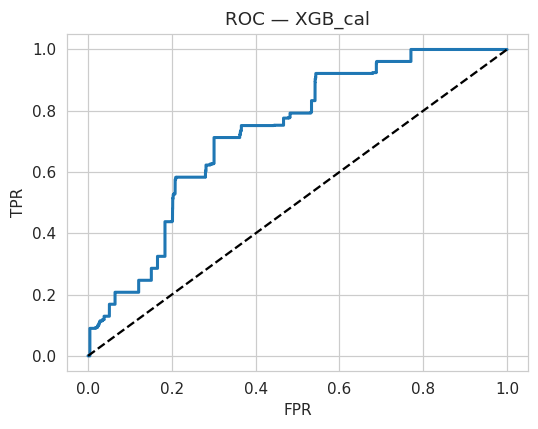

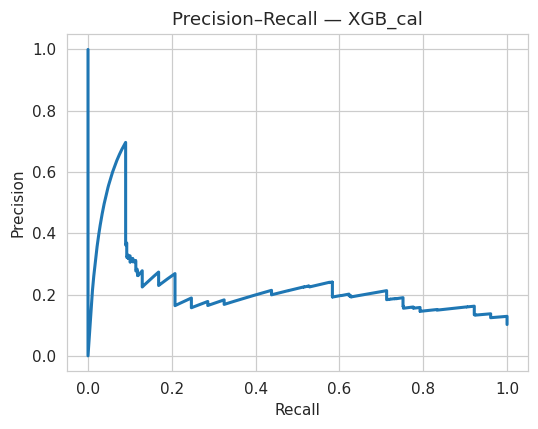

In [27]:
# === Cell 12: Cost-sensitive Binary Classification (policy-friendly) ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, roc_auc_score, balanced_accuracy_score,
    f1_score, precision_score, recall_score, confusion_matrix,
    precision_recall_curve, average_precision_score, roc_curve
)

SPI_TO_CLASSIFY = "SPI_3"  # or "SPI_6" / "SPI_12"
cls_train = train_df.copy(); cls_test = test_df.copy()
cls_train["y_bin"] = (cls_train[f"{SPI_TO_CLASSIFY}_future"] < -1.0).astype(int)
cls_test["y_bin"]  = (cls_test[f"{SPI_TO_CLASSIFY}_future"]  < -1.0).astype(int)

# time-aware validation (last train year)
val_year = cls_train["label_date"].dt.year.max()
tr_mask = cls_train["label_date"].dt.year < val_year
va_mask = cls_train["label_date"].dt.year == val_year

X_tr = preprocessor.transform(cls_train.loc[tr_mask, feature_cols])
y_tr = cls_train.loc[tr_mask, "y_bin"].values
X_va = preprocessor.transform(cls_train.loc[va_mask, feature_cols])
y_va = cls_train.loc[va_mask, "y_bin"].values
X_te = preprocessor.transform(cls_test[feature_cols])
y_te = cls_test["y_bin"].values

neg, pos = (y_tr==0).sum(), (y_tr==1).sum()
scale_pos = neg / max(1,pos)

models_cls = {
    "Logistic": LogisticRegression(max_iter=5000, class_weight="balanced", random_state=CFG["random_state"]),
    "RF_cal":   CalibratedClassifierCV(RandomForestClassifier(
                    n_estimators=1000, class_weight="balanced", n_jobs=-1, random_state=CFG["random_state"]
                ), method="sigmoid", cv=3)
}
try:
    import xgboost as xgb
    models_cls["XGB_cal"] = CalibratedClassifierCV(xgb.XGBClassifier(
        n_estimators=1200, learning_rate=0.03, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
        objective="binary:logistic", n_jobs=-1, random_state=CFG["random_state"], tree_method="hist",
        scale_pos_weight=scale_pos, eval_metric="aucpr"
    ), method="sigmoid", cv=3)
except Exception:
    pass

def pick_threshold(probs, y_true, *, target_recall=None, beta=2.0):
    if target_recall is not None:
        ts = np.linspace(0.01, 0.99, 99)
        for t in ts:
            if recall_score(y_true, (probs>=t).astype(int), zero_division=0) >= target_recall:
                return t
        return 0.5
    # else F2
    ts = np.linspace(0.01, 0.9, 60)
    best_t, best_s = 0.5, -1
    for t in ts:
        pred = (probs>=t).astype(int)
        p = precision_score(y_true, pred, zero_division=0)
        r = recall_score(y_true, pred, zero_division=0)
        s = (1+beta**2)*p*r / (beta**2*p + r + 1e-9)
        if s>best_s: best_s, best_t = s, t
    return best_t

rows = []
for name, mdl in models_cls.items():
    mdl.fit(X_tr, y_tr)
    probs_va = mdl.predict_proba(X_va)[:,1]
    # Choose threshold: target recall 0.60 (change if you prefer)
    t_opt = pick_threshold(probs_va, y_va, target_recall=0.60)
    probs_te = mdl.predict_proba(X_te)[:,1]
    pred_te = (probs_te >= t_opt).astype(int)

    bal = balanced_accuracy_score(y_te, pred_te)
    f1  = f1_score(y_te, pred_te)
    rec = recall_score(y_te, pred_te); prec = precision_score(y_te, pred_te)
    auc = roc_auc_score(y_te, probs_te); ap = average_precision_score(y_te, probs_te)
    cm  = confusion_matrix(y_te, pred_te)
    print(f"\n{name}: thr={t_opt:.2f} | BalAcc={bal:.3f} F1={f1:.3f} Recall={rec:.3f} Precision={prec:.3f} | ROC-AUC={auc:.3f} PR-AUC={ap:.3f}")
    print("CM [[TN,FP],[FN,TP]]:\n", cm)
    print(classification_report(y_te, pred_te, digits=3))
    rows.append({"Model":name,"Threshold":t_opt,"BalancedAcc":bal,"F1":f1,"Recall":rec,"Precision":prec,"ROC_AUC":auc,"PR_AUC":ap,
                 "TN":cm[0,0],"FP":cm[0,1],"FN":cm[1,0],"TP":cm[1,1]})

cls_df = pd.DataFrame(rows).sort_values("F1", ascending=False)
cls_out = os.path.join(CFG["results_dir"], f"classification_metrics_{SPI_TO_CLASSIFY}.csv")
cls_df.to_csv(cls_out, index=False); print("📄 Saved →", cls_out); display(cls_df)

# Curves for best classifier
best_name = cls_df.iloc[0]["Model"]
probs_best = models_cls[best_name].predict_proba(X_te)[:,1]
fpr, tpr, _ = roc_curve(y_te, probs_best)
prec, rec, _ = precision_recall_curve(y_te, probs_best)

plt.figure(figsize=(5,4)); plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],'--',c='k')
plt.title(f"ROC — {best_name}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.tight_layout()
plt.savefig(os.path.join(CFG["results_dir"], f"roc_{SPI_TO_CLASSIFY}_{best_name}.png")); plt.show()

plt.figure(figsize=(5,4)); plt.plot(rec, prec, lw=2)
plt.title(f"Precision–Recall — {best_name}"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.tight_layout()
plt.savefig(os.path.join(CFG["results_dir"], f"pr_{SPI_TO_CLASSIFY}_{best_name}.png")); plt.show()


Best SPI_12 model: GradientBoosting
Saved regional error table → /home/abdi/drought-prediction/dissertation_results/regional_error_SPI12.csv


,RMSE,MAE,R2
ADM0_NAME,,,
Kenya,0.369,0.287,0.848
Uganda,0.439,0.325,0.515
Somalia,0.551,0.442,0.861
Ethiopia,1.013,0.451,0.536


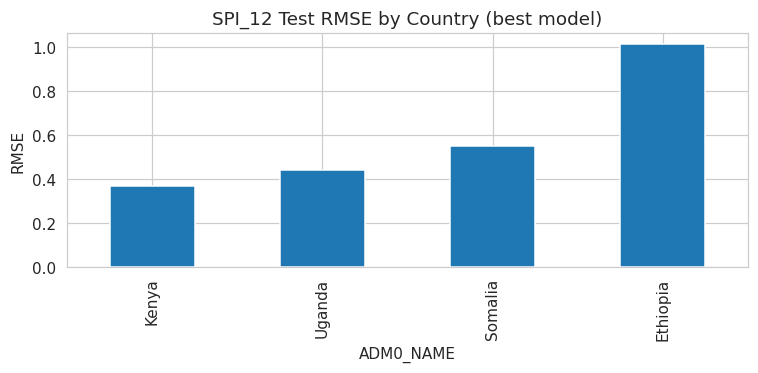

In [28]:
# === Cell 13: Regional Error Breakdown (SPI_12) ===
def error_by_country(target, model_name):
    yhat = y_pers_test[target] if model_name=="Persistence" else trained_models[target][model_name].predict(X_test)
    z = test_df[[target,"ADM0_NAME"]].copy()
    z["y_true"] = y_test[target]; z["y_pred"] = yhat
    out = z.groupby("ADM0_NAME").apply(lambda g: pd.Series({
        "RMSE": np.sqrt(((g["y_true"]-g["y_pred"])**2).mean()),
        "MAE":  (g["y_true"]-g["y_pred"]).abs().mean(),
        "R2":   1 - ((g["y_true"]-g["y_pred"])**2).sum() / ((g["y_true"]-g["y_true"].mean())**2).sum()
    })).sort_values("RMSE")
    return out

best_spi12 = res_df[res_df["Target"]=="SPI_12"].iloc[0]["Model"]
print("Best SPI_12 model:", best_spi12)
reg_tbl = error_by_country("SPI_12", best_spi12).round(3)
outp = os.path.join(CFG["results_dir"], "regional_error_SPI12.csv")
reg_tbl.to_csv(outp)
print("Saved regional error table →", outp)
display(reg_tbl)

ax = reg_tbl["RMSE"].sort_values().plot(kind="bar", figsize=(7,3.5), title="SPI_12 Test RMSE by Country (best model)")
ax.set_ylabel("RMSE"); plt.tight_layout()
plt.savefig(os.path.join(CFG["results_dir"], "spi12_rmse_by_country.png")); plt.show()


Naive quantile PI(10–90) coverage=34.02% | RMSE(center)=0.601
Conformal 90% PI coverage=99.59%; half-width≈2.042


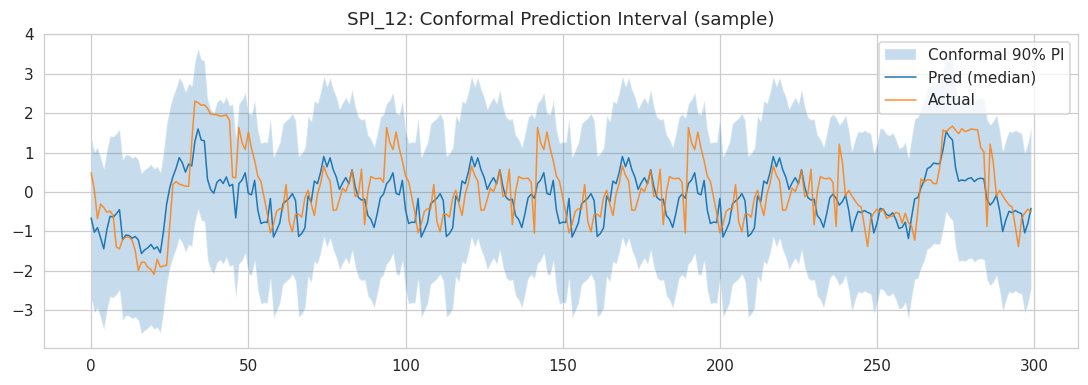

In [29]:
# === Cell 14: Uncertainty — Quantile GB + Conformal (calibrated bands) ===
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import clone

def quantile_gb(alpha):
    return GradientBoostingRegressor(
        loss="quantile", alpha=alpha, n_estimators=700, learning_rate=0.05,
        max_depth=3, subsample=0.9, random_state=CFG["random_state"]
    )

# Naïve quantile bands (10–90)
gb_low  = clone(quantile_gb(0.10)).fit(X_train, y_train["SPI_12"])
gb_med  = GradientBoostingRegressor(n_estimators=700, learning_rate=0.05, max_depth=3, subsample=0.9,
                                    random_state=CFG["random_state"]).fit(X_train, y_train["SPI_12"])
gb_high = clone(quantile_gb(0.90)).fit(X_train, y_train["SPI_12"])

lo_q  = gb_low.predict(X_test); med = gb_med.predict(X_test); hi_q = gb_high.predict(X_test)
rmse = np.sqrt(((y_test["SPI_12"]-med)**2).mean())
cov_q = np.mean((y_test["SPI_12"]>=lo_q) & (y_test["SPI_12"]<=hi_q))
print(f"Naive quantile PI(10–90) coverage={cov_q:.2%} | RMSE(center)={rmse:.3f}")

# Split-conformal 90% band around median — reliable marginal coverage
cal_year = train_df["label_date"].dt.year.max()
fit_mask = train_df["label_date"].dt.year < cal_year
cal_mask = train_df["label_date"].dt.year == cal_year
X_fit = preprocessor.transform(train_df.loc[fit_mask, feature_cols])
y_fit = train_df.loc[fit_mask, "SPI_12_future"].values
X_cal = preprocessor.transform(train_df.loc[cal_mask, feature_cols])
y_cal = train_df.loc[cal_mask, "SPI_12_future"].values

gb_center = GradientBoostingRegressor(n_estimators=700, learning_rate=0.05, max_depth=3, subsample=0.9,
                                      random_state=CFG["random_state"]).fit(X_fit, y_fit)
alpha = 0.10
q_hat = np.quantile(np.abs(y_cal - gb_center.predict(X_cal)), 1 - alpha)
med_c = gb_center.predict(X_test); L = med_c - q_hat; U = med_c + q_hat
cov_c = np.mean((y_test["SPI_12"]>=L) & (y_test["SPI_12"]<=U))
print(f"Conformal 90% PI coverage={cov_c:.2%}; half-width≈{q_hat:.3f}")

# Plot sample
idx = np.arange(min(300, len(med)))
plt.figure(figsize=(10,3.6))
plt.fill_between(idx, L[:len(idx)], U[:len(idx)], alpha=0.25, label="Conformal 90% PI")
plt.plot(idx, med_c[:len(idx)], lw=1, label="Pred (median)")
plt.plot(idx, y_test["SPI_12"][:len(idx)], lw=1, alpha=0.85, label="Actual")
plt.title("SPI_12: Conformal Prediction Interval (sample)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(CFG["results_dir"], "spi12_conformal_interval.png")); plt.show()
